# Proyek Klasifikasi Gambar: [Indonesian Food]
- **Nama:** Muhammad Rizeky Rahmatullah
- **Email:** muhammadrizeky64@gmail.com
- **ID Dicoding:** rizekyr

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
!pip install tensorflowjs
import tensorflowjs as tfjs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
from google.colab import drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


## Data *Preparation*



### Data Loading

In [2]:
drive.mount('/content/drive', force_remount = True)

# check Indonesian food direktori
data_dir= '/content/drive/MyDrive/dataset indonesian food'
os.listdir(data_dir)

Mounted at /content/drive


['Gado-Gado', 'Mie Goreng', 'Ayam Goreng', 'Sate']

In [3]:
#Menyimpan variable path sesuai dengan direktorinya
ayam_dir = os.path.join(data_dir, 'Ayam Goreng')
gado_dir = os.path.join(data_dir, 'Gado-Gado')
mie_dir = os.path.join(data_dir, 'Mie Goreng')
sate_dir = os.path.join(data_dir, 'Sate')
os.listdir(data_dir)

['Gado-Gado', 'Mie Goreng', 'Ayam Goreng', 'Sate']

In [4]:
#print jumlah setiap Image
print(f"Ayam Goreng \t: {len(os.listdir(ayam_dir))} images")
print(f"Gado-gado \t: {len(os.listdir(gado_dir))} images")
print(f"Mie Goreng \t: {len(os.listdir(mie_dir))} images")
print(f"Sate \t\t: {len(os.listdir(sate_dir))} images")

Ayam Goreng 	: 487 images
Gado-gado 	: 488 images
Mie Goreng 	: 492 images
Sate 		: 487 images


### Menampilkan beberapa gambar dari setiap kelas

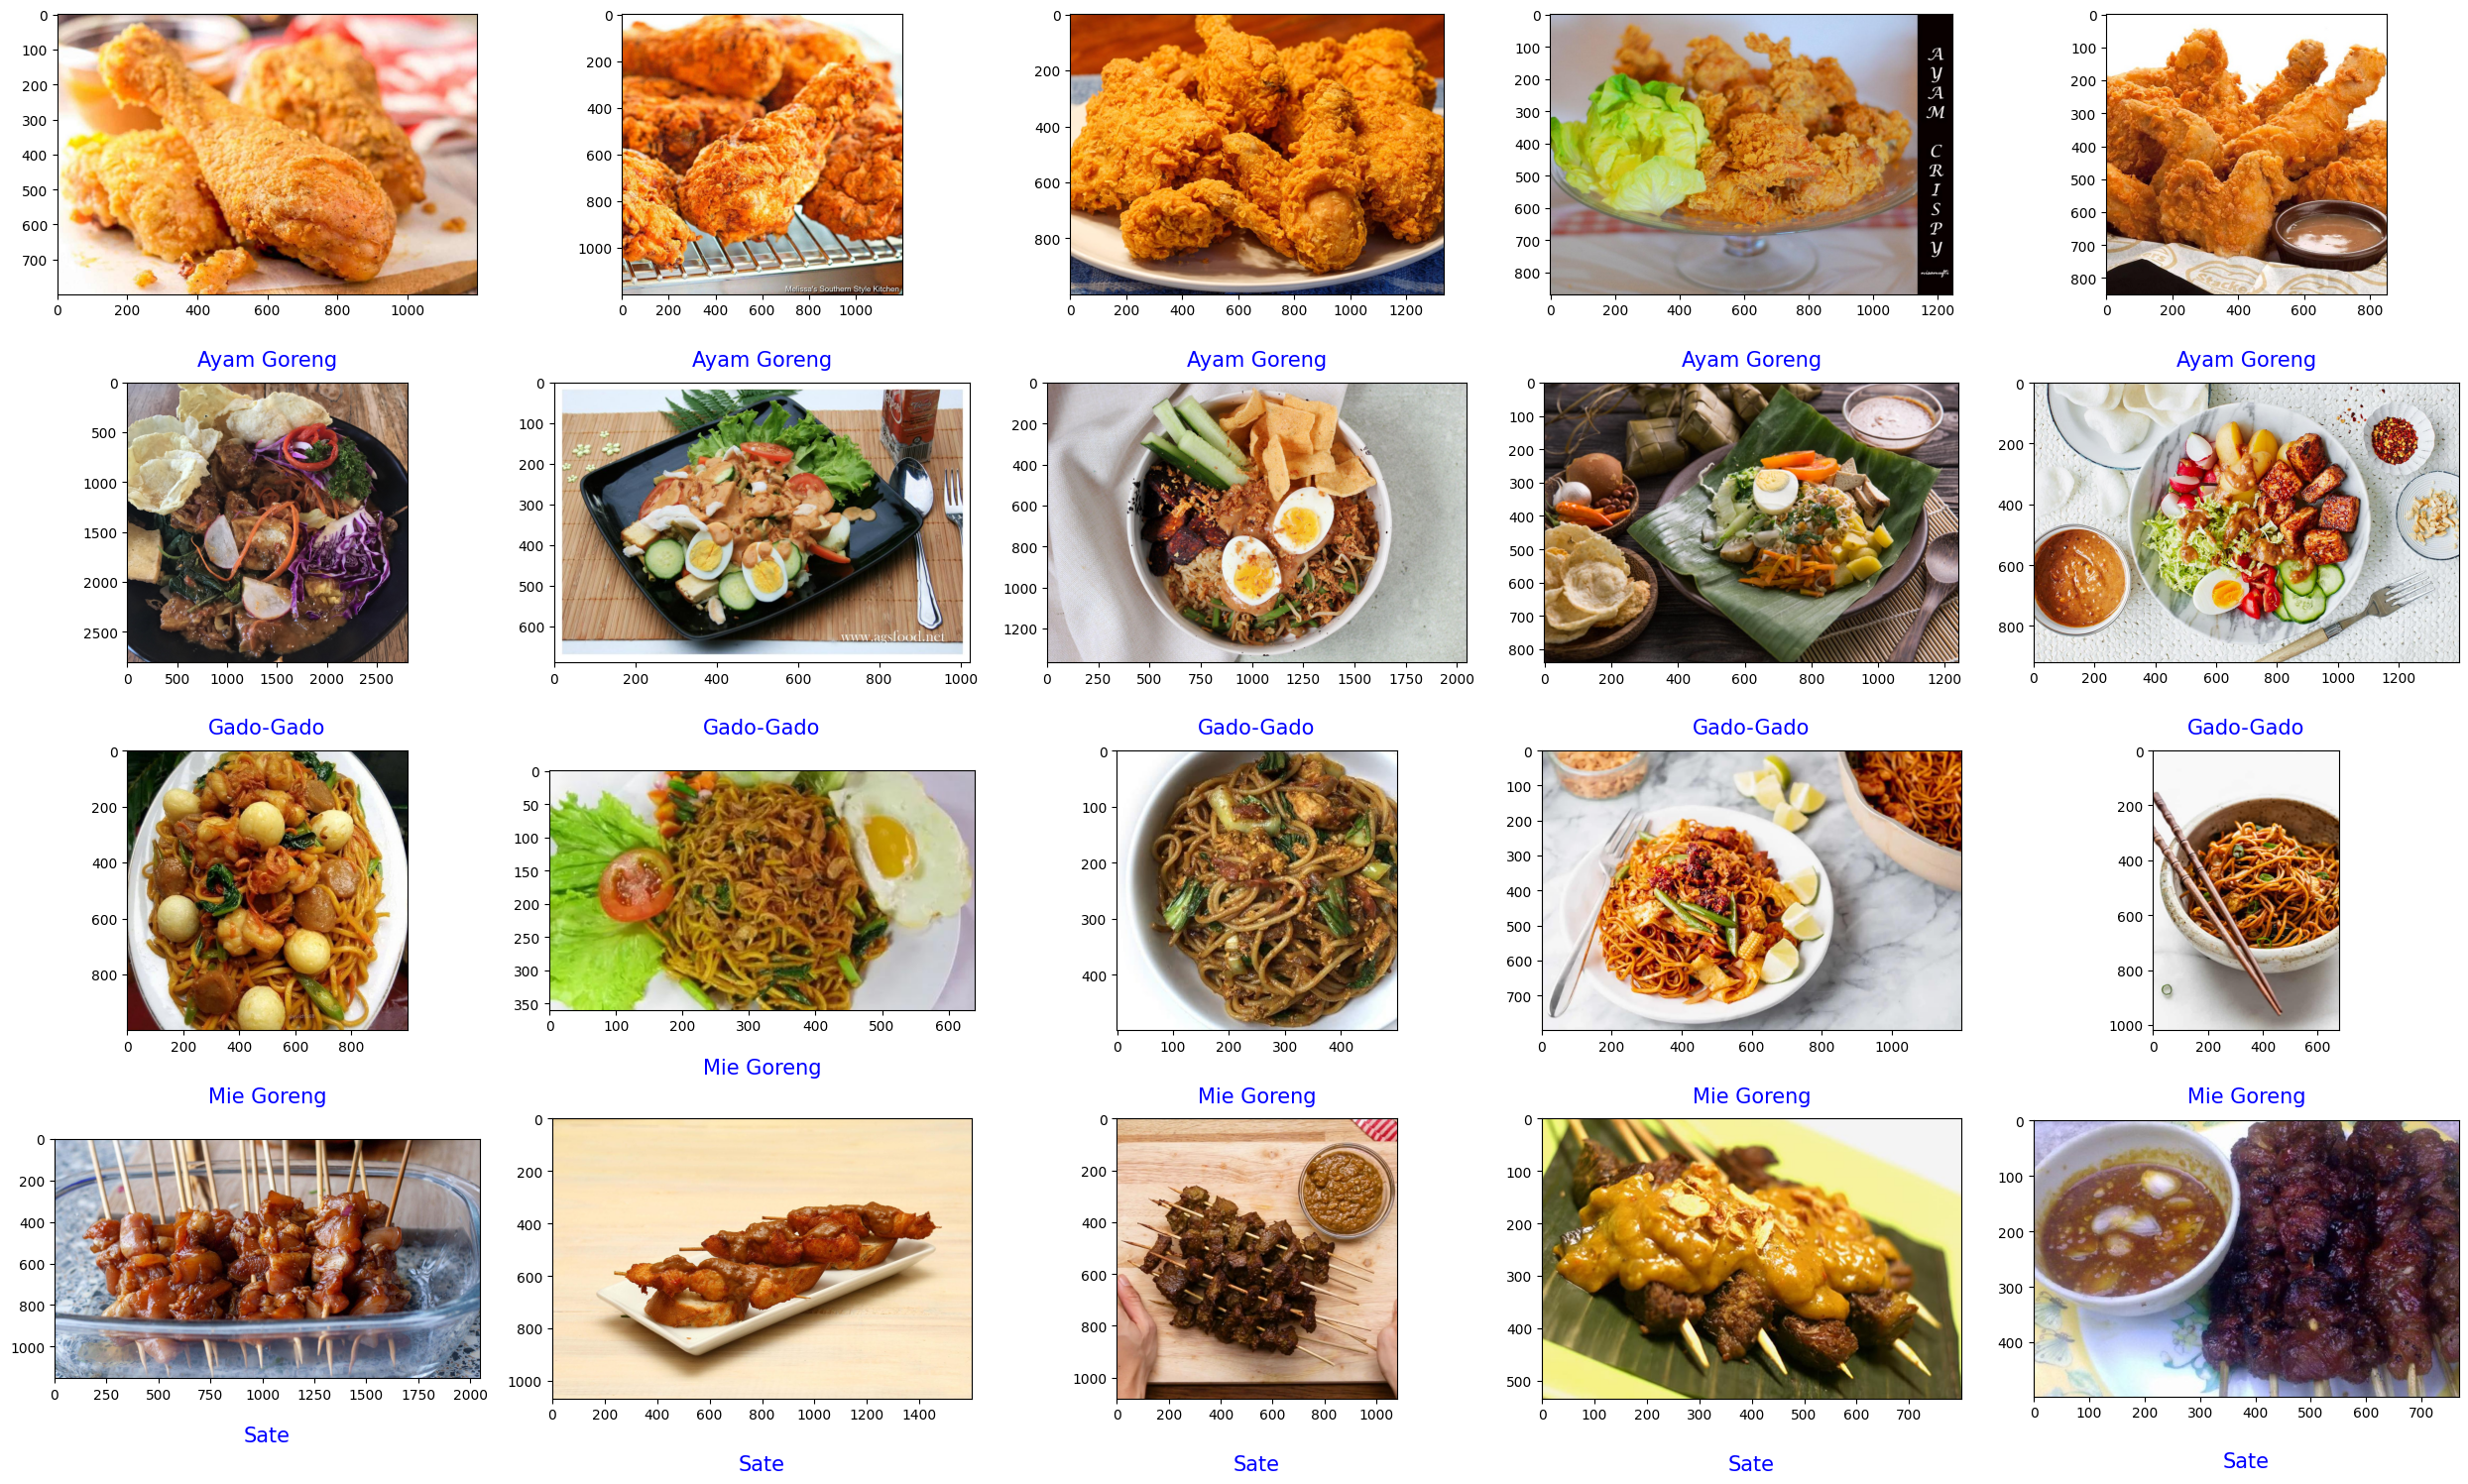

In [5]:
# List direktori dan label kelas
class_dirs = [ayam_dir, gado_dir, mie_dir, sate_dir]
class_names = ['Ayam Goreng', 'Gado-Gado', 'Mie Goreng', 'Sate']

# Tampilkan 5 gambar per kelas
plt.figure(figsize=(25, 15))  # Atur ukuran plot

num_images = 5  # Jumlah gambar yang akan ditampilkan per kelas

for i, (class_dir, class_name) in enumerate(zip(class_dirs, class_names)):
    # Ambil semua file dan acak urutannya
    all_files = os.listdir(class_dir)
    random.shuffle(all_files)  # Acak urutan file
    filenames = all_files[:num_images]  # Ambil 5 gambar acak

    for j, filename in enumerate(filenames):
        # Buat subplot grid 3 baris x 5 kolom
        ax = plt.subplot(len(class_dirs), num_images, i * num_images + j + 1)

        # Baca dan tampilkan gambar
        img = mpimg.imread(os.path.join(class_dir, filename))
        plt.imshow(img)
        plt.axis('on')

        # label kelas di bawah gambar
        plt.text(0.5, -0.2, class_name,
                 ha='center',
                 va='top',
                 transform=ax.transAxes,
                 fontsize=15,
                 color='blue')

# Jarak antar baris & # Jarak horizontal
plt.subplots_adjust(hspace=0.5, wspace=0.2, top=1)
plt.tight_layout()
plt.show()

### Data Preprocessing

In [6]:
dataset_dir = '/content/drive/MyDrive/dataset indonesian food/dataset'
# Membuat direktori "submission"
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print(f"Direktori 'dataset' telah berhasil dibuat di {dataset_dir}")
else:
    print(f"Direktori 'dataset' sudah ada di {dataset_dir}")

Direktori 'dataset' telah berhasil dibuat di /content/drive/MyDrive/dataset indonesian food/dataset


#### Split Dataset

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Buat direktori train,val dan test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List kelas
classes = ['Ayam Goreng', 'Gado-Gado', 'Mie Goreng', 'Sate']

def resize_and_save_images(image_paths, target_dir):
    os.makedirs(target_dir, exist_ok=True)

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((256, 256))  # Resize gambar ke 150x150
        filename = os.path.basename(img_path)
        img.save(os.path.join(target_dir, filename))

for cls in classes:
    # Path kelas asli
    class_dir = os.path.join(data_dir, cls)

    # Dapatkan list file gambar
    all_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg'))]

    # Split 70-30 terlebih dahulu
    train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)

    # Split 50-50 dari 30% untuk val dan test (15% masing-masing)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Buat direktori kelas di train,val dan test
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Resize dan simpan gambar ke direktori train
    resize_and_save_images(train_files, os.path.join(train_dir, cls))

    for f in val_files:
        src = os.path.join(class_dir, f)
        dst = os.path.join(val_dir, cls)
        shutil.copy2(src, dst)

    for f in test_files:
        src = os.path.join(class_dir, f)
        dst = os.path.join(test_dir, cls)
        shutil.copy2(src, dst)


In [8]:
print("Pembagian dataset selesai!")
for cls in classes:
    print(f"\nKelas {cls}:")
    print(f"Train: {len(os.listdir(os.path.join(train_dir, cls)))} images")
    print(f"Train: {len(os.listdir(os.path.join(val_dir, cls)))} images")
    print(f"Test: {len(os.listdir(os.path.join(test_dir, cls)))} images")

Pembagian dataset selesai!

Kelas Ayam Goreng:
Train: 340 images
Train: 73 images
Test: 74 images

Kelas Gado-Gado:
Train: 340 images
Train: 73 images
Test: 73 images

Kelas Mie Goreng:
Train: 343 images
Train: 74 images
Test: 74 images

Kelas Sate:
Train: 340 images
Train: 73 images
Test: 74 images


### Visualisasi Data

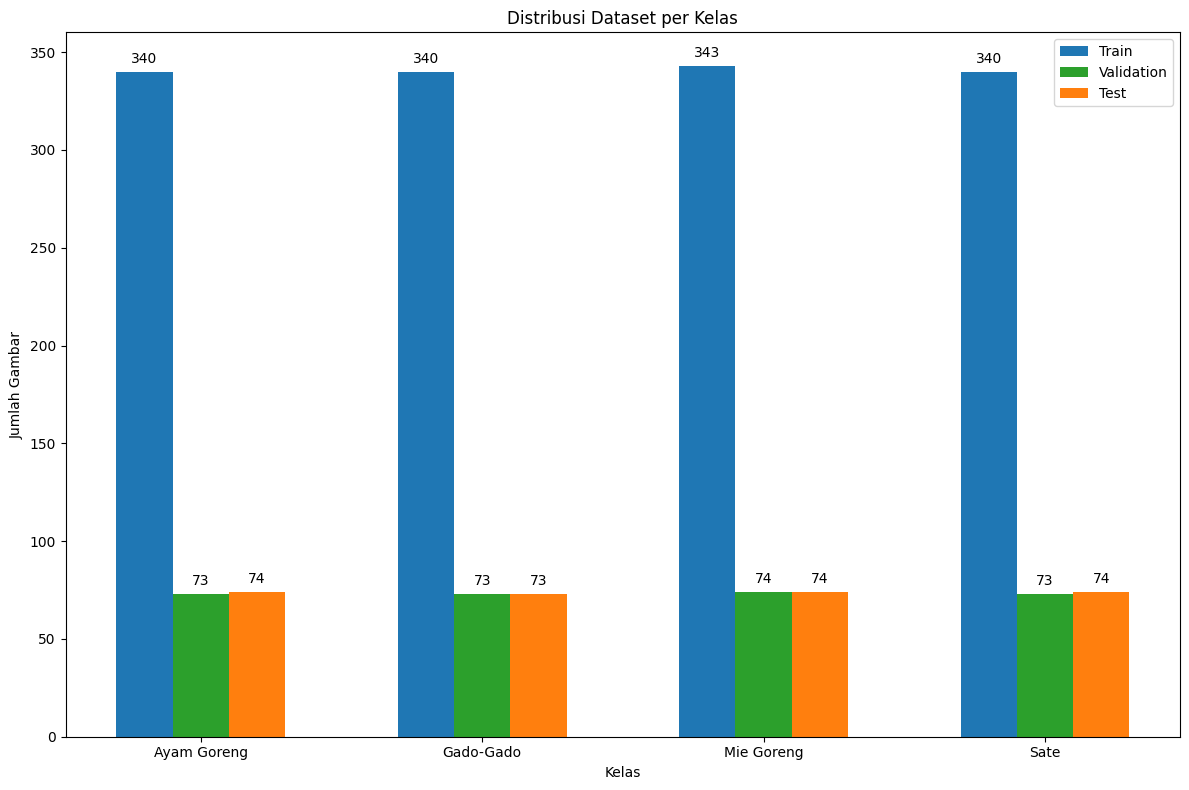

In [9]:
# Ambil jumlah data dari folder
train_counts = []
val_counts = []
test_counts = []

for cls in classes:
    # Hitung file di folder train
    train_class_dir = os.path.join(train_dir, cls)
    train_files = [f for f in os.listdir(train_class_dir) if os.path.isfile(os.path.join(train_class_dir, f))]
    train_counts.append(len(train_files))

    val_class_dir = os.path.join(val_dir, cls)
    val_files = [f for f in os.listdir(val_class_dir) if os.path.isfile(os.path.join(val_class_dir, f))]
    val_counts.append(len(val_files))

    # Hitung file di folder test
    test_class_dir = os.path.join(test_dir, cls)
    test_files = [f for f in os.listdir(test_class_dir) if os.path.isfile(os.path.join(test_class_dir, f))]
    test_counts.append(len(test_files))

# Visualisasi
plt.figure(figsize=(12, 8))
x = np.arange(len(classes))
width = 0.2

bars_train = plt.bar(x - width, train_counts, width, label='Train', color='#1f77b4')
bars_val = plt.bar(x, val_counts, width, label='Validation', color='#2ca02c')
bars_test = plt.bar(x + width, test_counts, width, label='Test', color='#ff7f0e')

plt.title('Distribusi Dataset per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(x, classes)
plt.legend()

# Tambahkan label angka
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + 3,
                 f'{height}',
                 ha='center',
                 va='bottom',
                 fontsize=10)

plt.tight_layout()
plt.show()

### Data Augmentation

In [10]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20,
    fill_mode='nearest',
)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk validation
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 1363 images belonging to 4 classes.
Found 293 images belonging to 4 classes.
Found 295 images belonging to 4 classes.


## Modelling

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3), kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.05)),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.5),


    Dense(4, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │              

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/indonesian_food_model/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=70,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.3133 - loss: 20.0304

43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3146 - loss: 19.8689 - val_accuracy: 0.2491 - val_loss: 5.0616 - learning_rate: 0.0030
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.4824 - loss: 3.3404

43/43 ━━━━━━━━━━━━━━━━━━━━ 56s 779ms/step - accuracy: 0.4825 - loss: 3.3267 - val_accuracy: 0.2594 - val_loss: 2.3853 - learning_rate: 0.0030
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4902 - loss: 1.8399

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 741ms/step - accuracy: 0.4907 - loss: 1.8377 - val_accuracy: 0.2765 - val_loss: 1.8570 - learning_rate: 0.0030
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 757ms/step - accuracy: 0.5701 - loss: 1.5320 - val_accuracy: 0.2491 - val_loss: 2.2176 - learning_rate: 0.0030
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 771ms/step - accuracy: 0.6163 - loss: 1.4692 - val_accuracy: 0.2628 - val_loss: 1.9170 - learning_rate: 0.0030
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.5884 - loss: 1.4540 - val_accuracy: 0.2594 - val_loss: 1.9147 - learning_rate: 0.0030
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.6331 - loss: 1.3936

43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 732ms/step - accuracy: 0.6332 - loss: 1.3940 - val_accuracy: 0.3174 - val_loss: 1.8347 - learning_rate: 0.0030
Epoch 8/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.6476 - loss: 1.3957

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 776ms/step - accuracy: 0.6474 - loss: 1.3963 - val_accuracy: 0.5461 - val_loss: 1.5409 - learning_rate: 0.0030
Epoch 9/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.6116 - loss: 1.4261 - val_accuracy: 0.3925 - val_loss: 1.7504 - learning_rate: 0.0030
Epoch 10/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 717ms/step - accuracy: 0.6525 - loss: 1.4034 - val_accuracy: 0.2696 - val_loss: 2.0337 - learning_rate: 0.0030
Epoch 11/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 719ms/step - accuracy: 0.6448 - loss: 1.4190 - val_accuracy: 0.3720 - val_loss: 2.1319 - learning_rate: 0.0030
Epoch 12/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 762ms/step - accuracy: 0.6271 - loss: 1.4529 - val_accuracy: 0.4881 - val_loss: 1.6779 - learning_rate: 0.0030
Epoch 13/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.6261 - loss: 1.4825 - val_accuracy: 0.4846 - val_loss: 1.6792 - learning_rate: 0.0030
Epoch 14/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6964 - loss: 1.3107

43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 740ms/step - accuracy: 0.6964 - loss: 1.3089 - val_accuracy: 0.6416 - val_loss: 1.2428 - learning_rate: 0.0015
Epoch 15/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 723ms/step - accuracy: 0.7073 - loss: 1.1184 - val_accuracy: 0.4369 - val_loss: 1.4740 - learning_rate: 0.0015
Epoch 16/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 721ms/step - accuracy: 0.7130 - loss: 1.0818 - val_accuracy: 0.6041 - val_loss: 1.2099 - learning_rate: 0.0015
Epoch 17/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 762ms/step - accuracy: 0.7251 - loss: 1.1101 - val_accuracy: 0.5631 - val_loss: 1.3244 - learning_rate: 0.0015
Epoch 18/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 764ms/step - accuracy: 0.7275 - loss: 1.0924 - val_accuracy: 0.4471 - val_loss: 1.5906 - learning_rate: 0.0015
Epoch 19/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.7103 - loss: 1.1209

43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 725ms/step - accuracy: 0.7106 - loss: 1.1207 - val_accuracy: 0.6485 - val_loss: 1.2663 - learning_rate: 0.0015
Epoch 20/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 717ms/step - accuracy: 0.7053 - loss: 1.1093 - val_accuracy: 0.5085 - val_loss: 1.5199 - learning_rate: 0.0015
Epoch 21/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7482 - loss: 1.0202

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 742ms/step - accuracy: 0.7475 - loss: 1.0220 - val_accuracy: 0.6724 - val_loss: 1.1952 - learning_rate: 0.0015
Epoch 22/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7730 - loss: 1.0168

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 735ms/step - accuracy: 0.7730 - loss: 1.0167 - val_accuracy: 0.6928 - val_loss: 1.0624 - learning_rate: 0.0015
Epoch 23/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 714ms/step - accuracy: 0.7579 - loss: 1.0045 - val_accuracy: 0.5870 - val_loss: 1.3282 - learning_rate: 0.0015
Epoch 24/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 734ms/step - accuracy: 0.7415 - loss: 1.0214 - val_accuracy: 0.4471 - val_loss: 2.1165 - learning_rate: 0.0015
Epoch 25/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 717ms/step - accuracy: 0.7766 - loss: 0.9865 - val_accuracy: 0.3242 - val_loss: 4.3018 - learning_rate: 0.0015
Epoch 26/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 753ms/step - accuracy: 0.7347 - loss: 1.0782 - val_accuracy: 0.5119 - val_loss: 1.7254 - learning_rate: 0.0015
Epoch 27/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 730ms/step - accuracy: 0.7596 - loss: 1.0163 - val_accuracy: 0.5666 - val_loss: 1.3852 - learning_rate: 0.0015
Epoch 28/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 737ms/step - accuracy: 0.7831 - loss: 0.9344 

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 743ms/step - accuracy: 0.8066 - loss: 0.8580 - val_accuracy: 0.8089 - val_loss: 0.8446 - learning_rate: 7.5000e-04
Epoch 30/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 739ms/step - accuracy: 0.7743 - loss: 0.8617 - val_accuracy: 0.7509 - val_loss: 0.8734 - learning_rate: 7.5000e-04
Epoch 31/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 726ms/step - accuracy: 0.7870 - loss: 0.8328 - val_accuracy: 0.7918 - val_loss: 0.8490 - learning_rate: 7.5000e-04
Epoch 32/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 744ms/step - accuracy: 0.8028 - loss: 0.8501 - val_accuracy: 0.7270 - val_loss: 0.9628 - learning_rate: 7.5000e-04
Epoch 33/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 771ms/step - accuracy: 0.8024 - loss: 0.8051 - val_accuracy: 0.7509 - val_loss: 0.8870 - learning_rate: 7.5000e-04
Epoch 34/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 765ms/step - accuracy: 0.8311 - loss: 0.7550 - val_accuracy: 0.7850 - val_loss: 0.8304 - learning_rate: 7.5000e-04
Epoch 35/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 718ms/step - accuracy

43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 738ms/step - accuracy: 0.7941 - loss: 0.8379 - val_accuracy: 0.8225 - val_loss: 0.8107 - learning_rate: 7.5000e-04
Epoch 38/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 727ms/step - accuracy: 0.7940 - loss: 0.8073 - val_accuracy: 0.7611 - val_loss: 0.8752 - learning_rate: 7.5000e-04
Epoch 39/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 738ms/step - accuracy: 0.8195 - loss: 0.8294 - val_accuracy: 0.5222 - val_loss: 1.4084 - learning_rate: 7.5000e-04
Epoch 40/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 737ms/step - accuracy: 0.8479 - loss: 0.7149 - val_accuracy: 0.7713 - val_loss: 0.8331 - learning_rate: 7.5000e-04
Epoch 41/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 722ms/step - accuracy: 0.8131 - loss: 0.7779 - val_accuracy: 0.7338 - val_loss: 0.8835 - learning_rate: 7.5000e-04
Epoch 42/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 741ms/step - accuracy: 0.8467 - loss: 0.7232 - val_accuracy: 0.5870 - val_loss: 1.5354 - learning_rate: 7.5000e-04
Epoch 43/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 712ms/step - accuracy

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 743ms/step - accuracy: 0.8395 - loss: 0.6881 - val_accuracy: 0.8362 - val_loss: 0.7112 - learning_rate: 3.7500e-04
Epoch 45/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 725ms/step - accuracy: 0.8341 - loss: 0.7128 - val_accuracy: 0.7884 - val_loss: 0.8234 - learning_rate: 3.7500e-04
Epoch 46/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 723ms/step - accuracy: 0.8585 - loss: 0.6567 - val_accuracy: 0.7167 - val_loss: 1.0988 - learning_rate: 3.7500e-04
Epoch 47/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 737ms/step - accuracy: 0.8428 - loss: 0.6915 - val_accuracy: 0.7679 - val_loss: 0.8122 - learning_rate: 3.7500e-04
Epoch 48/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 754ms/step - accuracy: 0.8583 - loss: 0.6501 - val_accuracy: 0.7440 - val_loss: 0.9612 - learning_rate: 3.7500e-04
Epoch 49/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.8513 - loss: 0.7062 - val_accuracy: 0.6724 - val_loss: 1.1909 - learning_rate: 3.7500e-04
Epoch 50/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 722ms/step - accuracy

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 731ms/step - accuracy: 0.8721 - loss: 0.6228 - val_accuracy: 0.8840 - val_loss: 0.6174 - learning_rate: 1.8750e-04
Epoch 52/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 718ms/step - accuracy: 0.8643 - loss: 0.5968 - val_accuracy: 0.8635 - val_loss: 0.5994 - learning_rate: 1.8750e-04
Epoch 53/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 763ms/step - accuracy: 0.8720 - loss: 0.5798 - val_accuracy: 0.8123 - val_loss: 0.6895 - learning_rate: 1.8750e-04
Epoch 54/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 758ms/step - accuracy: 0.8746 - loss: 0.5841 - val_accuracy: 0.8771 - val_loss: 0.5596 - learning_rate: 1.8750e-04
Epoch 55/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 752ms/step - accuracy: 0.8727 - loss: 0.5756 - val_accuracy: 0.7782 - val_loss: 0.7858 - learning_rate: 1.8750e-04
Epoch 56/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 712ms/step - accuracy: 0.8823 - loss: 0.5519 - val_accuracy: 0.8840 - val_loss: 0.5576 - learning_rate: 1.8750e-04
Epoch 57/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 717ms/step - accuracy

## Evaluasi dan Visualisasi

In [13]:
# Evaluasi akhir dengan test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss}\n')

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step - accuracy: 0.8987 - loss: 0.5784

Test Accuracy: 86.44%
Test Loss: 0.6556594371795654



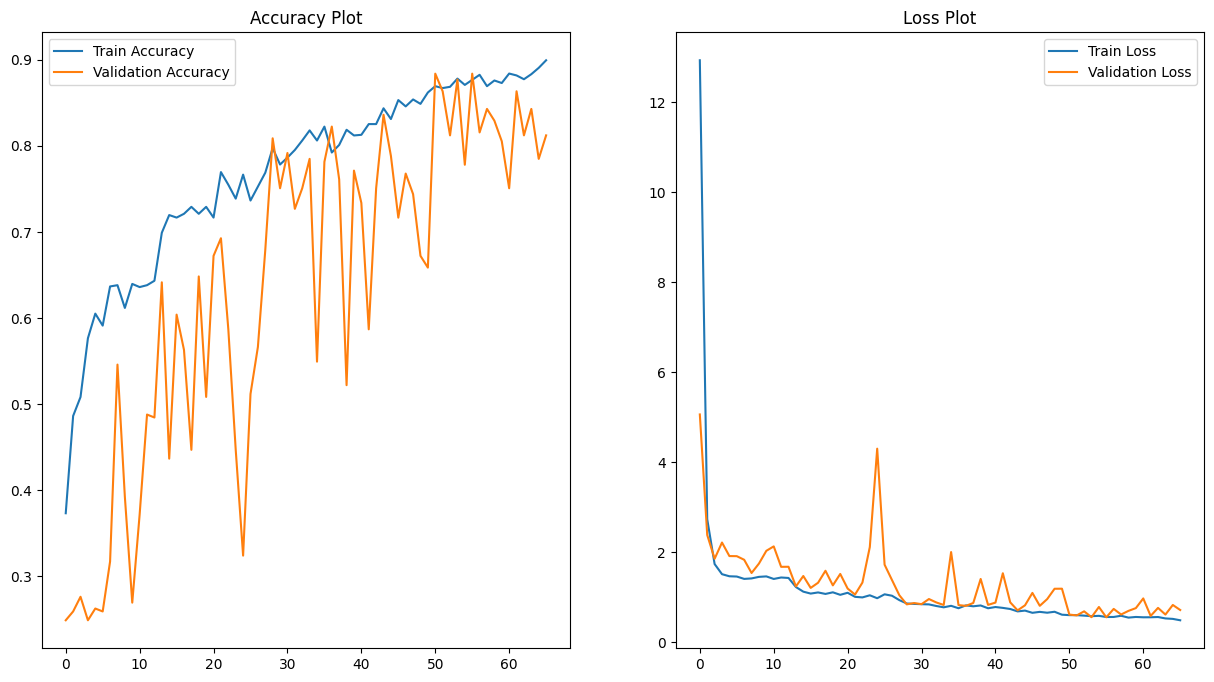

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step
              precision    recall  f1-score   support

 Ayam Goreng       0.84      0.92      0.88        74
   Gado-Gado       0.86      0.89      0.87        73
  Mie Goreng       0.89      0.95      0.92        74
        Sate       0.88      0.70      0.78        74

    accuracy                           0.86       295
   macro avg       0.87      0.86      0.86       295
weighted avg       0.87      0.86      0.86       295



In [14]:
# Plot Akurasi & Loss
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=classes))



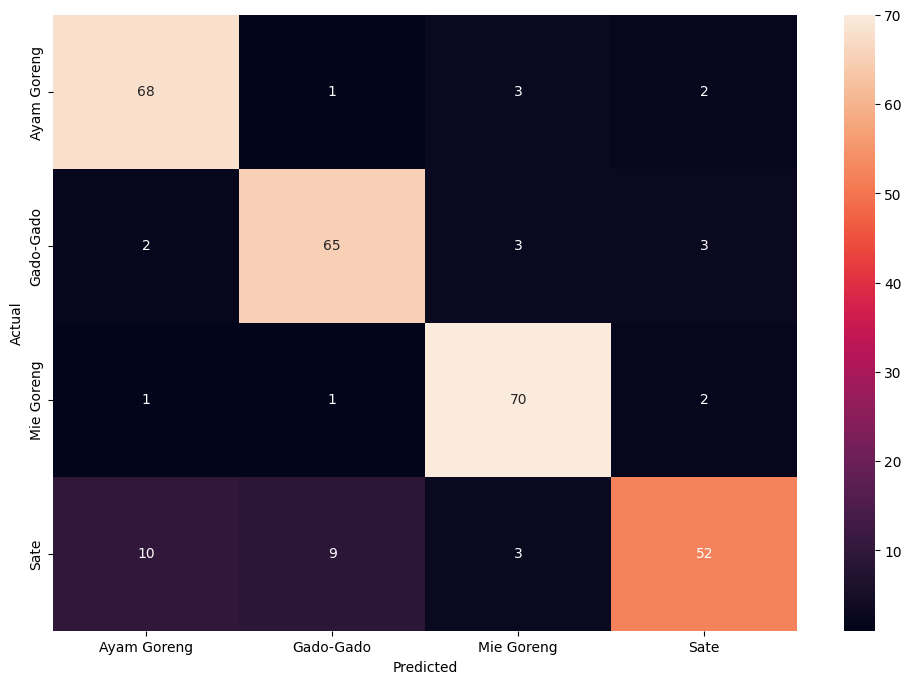

In [15]:
#Confussion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Prediksi Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


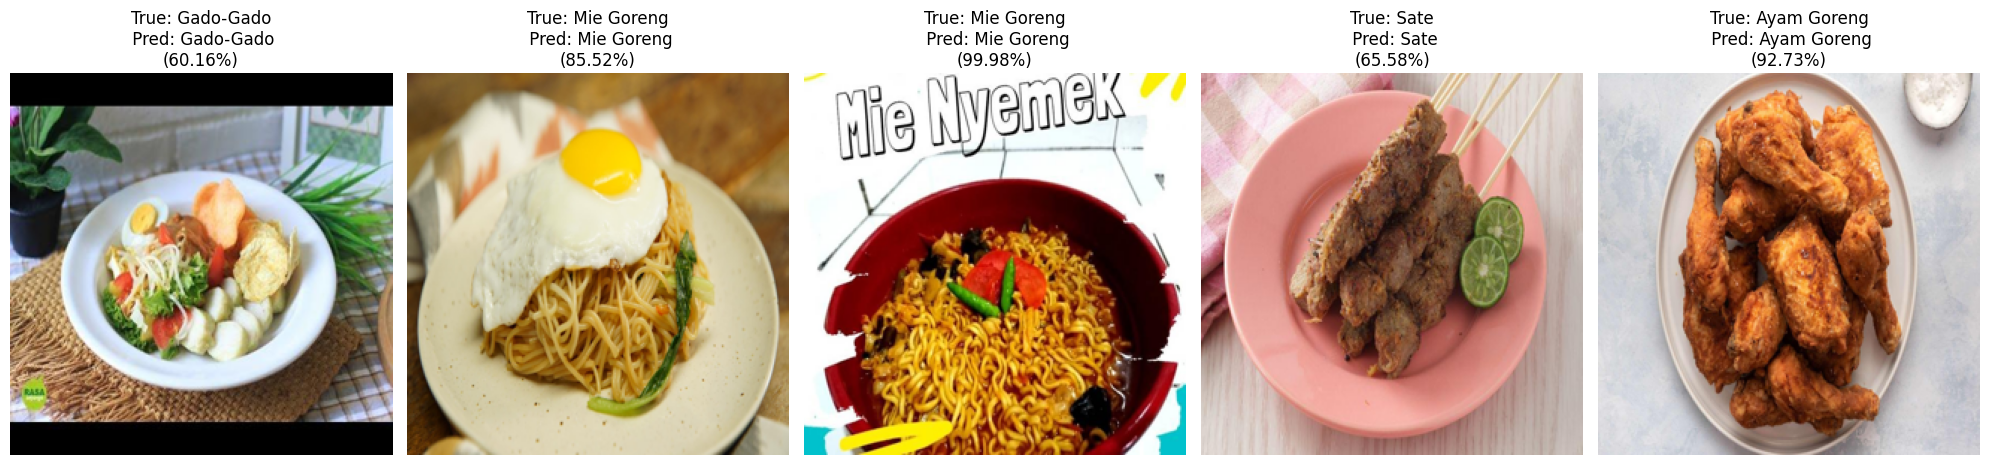

In [16]:
# Ambil 5 gambar acak dari folder test
all_test_images = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)]
    all_test_images.extend(images)

selected_images = random.sample(all_test_images, 5)

# Tampilkan gambar dengan prediksi
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(selected_images):

    true_class = os.path.basename(os.path.dirname(img_path))
    img = Image.open(img_path).convert('RGB')
    img = img.resize((256, 256))

    # Preprocessing untuk model
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    # Plot hasil
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'True: {true_class}\n Pred: {predicted_class}\n({confidence:.2f}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Konversi Model

In [17]:
# Buat direktori untuk menyimpan model
output_saved_model_dir = '/content/drive/MyDrive/indonesian_food_model'
saved_model_path = os.path.join(output_saved_model_dir, 'saved_model_model_1')
os.makedirs(saved_model_path, exist_ok=True)

# Simpan model dalam format SavedModel
tf.saved_model.save(model,saved_model_path)
print(f"\nModel berhasil dikonversi ke SavedModel format di direktori: {output_saved_model_dir}")



Model berhasil dikonversi ke SavedModel format di direktori: /content/drive/MyDrive/indonesian_food_model


In [18]:
#Tensorflow.js
# Konversi ke TensorFlow.js
tfjs_dir = os.path.join(output_saved_model_dir, 'tfjs_model_1')
os.makedirs(tfjs_dir, exist_ok=True)

# Convert model ke format TF.js
tfjs.converters.save_keras_model(model, tfjs_dir)
print(f"Model TensorFlow.js disimpan di: {tfjs_dir}")

#Tensorflow Lite
# Konversi ke TensorFlow Lite
tflite_dir = os.path.join(output_saved_model_dir, 'tflite_model_1')
os.makedirs(tflite_dir, exist_ok=True)

# Convert model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
tflite_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model TensorFlow Lite disimpan di: {tflite_path}")

# Kompres direktori model untuk download (opsional)
shutil.make_archive(output_saved_model_dir, 'zip', output_saved_model_dir)

failed to lookup keras version from the file,
    this is likely a weight only file
Model TensorFlow.js disimpan di: /content/drive/MyDrive/indonesian_food_model/tfjs_model_1
Saved artifact at '/tmp/tmpkrgdalkh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138418439580816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439580624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439580240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439581584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439580048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439581392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439581200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138418439583696: TensorSpec(shape=(), dtype=tf.re

'/content/drive/MyDrive/indonesian_food_model.zip'